In [1]:
import torch
import torch.nn as nn
import numpy as np 
import torch 
import torch.nn as nn
import os 
import glob
from PIL import Image
import torch.utils.data as data
from torchvision import models, transforms as T
from tqdm import tqdm_notebook
from torchvision import transforms, datasets
import torch.optim as optim
import time

### Implementation of VGG16
# ![title](vgg16.png)

In [3]:
class vgg16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu=nn.ReLU()
        self.bn_1=nn.BatchNorm2d(64)
        self.conv1_1=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.bn_2=nn.BatchNorm2d(128)
        self.conv2_1=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.bn_3=nn.BatchNorm2d(256)
        self.conv3_1=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.conv3_2=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.bn_4=nn.BatchNorm2d(512)
        self.conv4_1=nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.conv4_2=nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.conv5=nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.conv5_1=nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.conv5_2=nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.do = nn.Dropout(0.5) 
        self.fc1=nn.Linear(512*7*7,4096)
        self.fc2=nn.Linear(4096,4096)
        #Intel Image -- therefore 6
        self.fc3=nn.Linear(4096,2048)
        self.fc4=nn.Linear(2048,128)
        self.fc5=nn.Linear(128,6)
        
        
    def forward(self,x):
        x=self.relu(self.bn_1(self.conv1(x)))
        x=self.relu(self.bn_1(self.conv1_1(x)))
        x=self.pool(x)
        x=self.relu(self.bn_2(self.conv2(x)))
        x=self.pool(self.relu(self.bn_2(self.conv2_1(x))))
        x=self.relu(self.bn_3(self.conv3(x)))
        x=self.relu(self.bn_3(self.conv3_1(x)))
        x=self.pool(self.relu(self.bn_3(self.conv3_2(x))))
        x=self.relu(self.bn_4(self.conv4(x)))
        x=self.relu(self.bn_4(self.conv4_1(x)))
        x=self.pool(self.relu(self.bn_4(self.conv4_2(x))))
        x=self.relu(self.bn_4(self.conv5(x)))
        x=self.relu(self.bn_4(self.conv5_1(x)))
        x=self.pool(self.relu(self.bn_4(self.conv5_2(x))))
        x = torch.flatten(x, 1)
        x=self.do(self.relu(self.fc1(x)))
        x=self.do(self.relu(self.fc2(x)))
        x=self.do(self.relu(self.fc3(x)))
        x=self.do(self.relu(self.fc4(x)))
        x=self.fc5(x)
        return x        

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_data_dir = 'D:\\fastai\Beginning\pytorch\Chapters\Classification\seg_train\seg_train'
test_data_dir = 'D:\\fastai\Beginning\pytorch\Chapters\Classification\seg_test\seg_test'
batch_size=32

In [6]:

transform = transforms.Compose(
    [transforms.Resize([224,224]),
     transforms.ToTensor()
    ])

train_dataset = datasets.ImageFolder(train_data_dir, 
                               transform=transform)

train_dataloader = data.DataLoader(train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)
  
test_dataset = datasets.ImageFolder(test_data_dir, 
                               transform=transform)

test_dataloader = data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=True)

In [7]:

test_dataloader = data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=True)

In [8]:
model = vgg16()

if torch.cuda.is_available():
    model.cuda()
        
epochs = 2
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005,weight_decay=0.005,momentum=0.9)
train_losses = []
test_losses =[]
test_accuracy = []


In [9]:
training_loss=[]
def fit(epochs, model, criterion, optimizer, device=device, dataloader=train_dataloader):
    init=time.time()
    model.train()
    for e in range(epochs):
        running_loss = 0
        begin = time.time()
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
         
            running_loss += loss.data
        else:
            end = time.time()
            total_time=end-begin
            t_loss=running_loss/len(dataloader)
            training_loss.append(t_loss)
            print(f" Epoch {e}, Training loss: {running_loss/len(dataloader)}, time for this epoch {total_time}")   
    end_init=time.time()
    final_time=end_init-init
    print(f"Total time taken is {final_time} secs")

In [16]:
fit(epochs,model, criterion, optimizer)

 Epoch 0, Training loss: 0.6890828609466553, time for this epoch 143.54282402992249
 Epoch 1, Training loss: 0.5982454419136047, time for this epoch 135.652747631073
Total time taken is 279.7595534324646 secs


In [11]:
def predict(model, batch_size=32, device=device, dataloader=test_dataloader):
    classes = ('buildings', 'forest', 'glacier', 'mountain',
           'sea', 'street')
    
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(6)]
        n_class_samples = [0 for i in range(6)]
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
        
            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')

        for i in range(6):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')
        return outputs,images,labels

In [12]:
model.eval()
outputs,images,labels=predict(model)

Accuracy of the network: 14.583333333333334 %
Accuracy of buildings: 100.0 %
Accuracy of forest: 0.0 %
Accuracy of glacier: 0.0 %
Accuracy of mountain: 0.0 %
Accuracy of sea: 0.0 %
Accuracy of street: 0.0 %


In [13]:
outputs.shape,images.shape,labels.shape

(torch.Size([32, 6]), torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [14]:
labels[3]

tensor(1, device='cuda:0')

In [15]:
outputs

tensor([[ 4.6654, -2.7207, -1.5640, -1.7567,  0.6956,  1.4379],
        [ 3.2184, -1.9116, -1.0606, -1.2242,  0.4774,  1.0731],
        [ 3.0804, -1.6169, -1.0727, -1.4269,  0.2553,  1.4516],
        [ 5.5660, -2.7406, -1.9903, -2.4582,  0.3811,  2.2571],
        [ 3.2515, -1.8642, -1.0919, -1.3133,  0.4211,  1.1959],
        [ 4.1539, -2.2978, -1.4307, -1.7771,  0.4905,  1.6074],
        [ 5.0879, -2.4562, -1.8246, -2.2849,  0.2915,  2.1487],
        [ 5.7102, -2.8234, -2.0474, -2.5798,  0.4053,  2.3805],
        [ 4.2620, -2.3602, -1.4564, -1.7321,  0.5092,  1.5281],
        [ 4.6592, -2.7123, -1.5652, -1.7838,  0.6928,  1.4746],
        [ 2.7143, -1.5965, -0.8996, -1.0985,  0.3693,  1.0319],
        [ 2.6224, -1.4951, -0.8774, -1.0742,  0.3081,  1.0341],
        [ 4.8085, -2.4423, -1.7130, -2.2466,  0.3810,  2.1437],
        [ 3.5350, -2.0685, -1.1816, -1.4130,  0.5057,  1.2503],
        [ 2.5543, -1.4788, -0.8461, -1.0165,  0.3187,  0.9693],
        [ 5.2095, -2.6130, -1.8441, -2.2

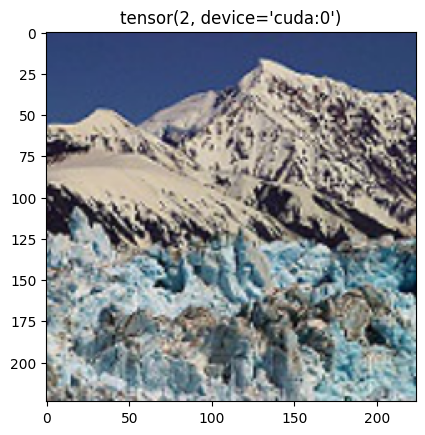

In [93]:
plot_img(10)

In [20]:
torch.save(model.state_dict(),"D:\\fastai\Beginning\pytorch\Chapters\Classification\paper_implementation\\model.pth")

In [13]:
model

vgg16(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), p

In [14]:
model2 = torch.load("D:\\fastai\Beginning\pytorch\Chapters\Classification\paper_implementation\\model.pth")

In [15]:
model2=vgg16()

In [16]:
model2.load_state_dict(torch.load("D:\\fastai\Beginning\pytorch\Chapters\Classification\paper_implementation\\model.pth"))

<All keys matched successfully>

In [17]:
model2.eval()
model2.to(device)
predict(model2)

Accuracy of the network: 14.885752688172044 %
Accuracy of buildings: 99.77011494252874 %
Accuracy of forest: 0.0 %
Accuracy of glacier: 0.0 %
Accuracy of mountain: 0.0 %
Accuracy of sea: 0.0 %
Accuracy of street: 1.8255578093306288 %


In [18]:
import tqdm

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Dec 25 21:55:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.47       Driver Version: 526.47       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 50%   50C    P2    88W / 200W |   3352MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
import matplotlib.pyplot as plt 


In [22]:
def plot_img(idx):
    plt.imshow(np.transpose(images[idx].cpu().detach().numpy(), (1, 2, 0)))
    plt.title(labels[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


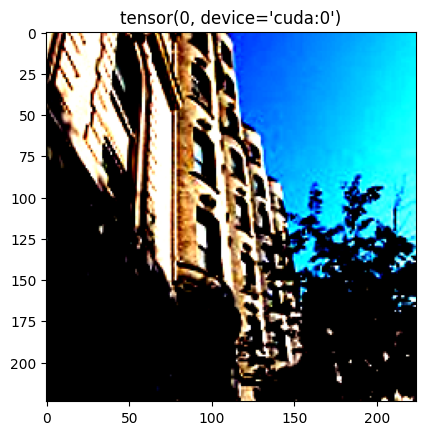

In [66]:
plot_img(21)

In [21]:
labels[6]

NameError: name 'labels' is not defined

In [31]:

TRAIN = "train"
VAL = "val"
INPUT_HEIGHT = 128
INPUT_WIDTH = 128
BATCH_SIZE = 16
VAL_SPLIT = 0.1

In [25]:
def visualize_batch(batch, classes, dataset_type):
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(BATCH_SIZE,BATCH_SIZE))
	for i in range(0, 32):
		ax = plt.subplot(4, 8, i + 1)
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")
		idx = batch[1][i]
		label = classes[idx]
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")
	plt.tight_layout()
	plt.show()

In [37]:
valBatch  = next(iter(test_dataloader))

In [38]:
classes = ('buildings', 'forest', 'glacier', 'mountain',
           'sea', 'street')

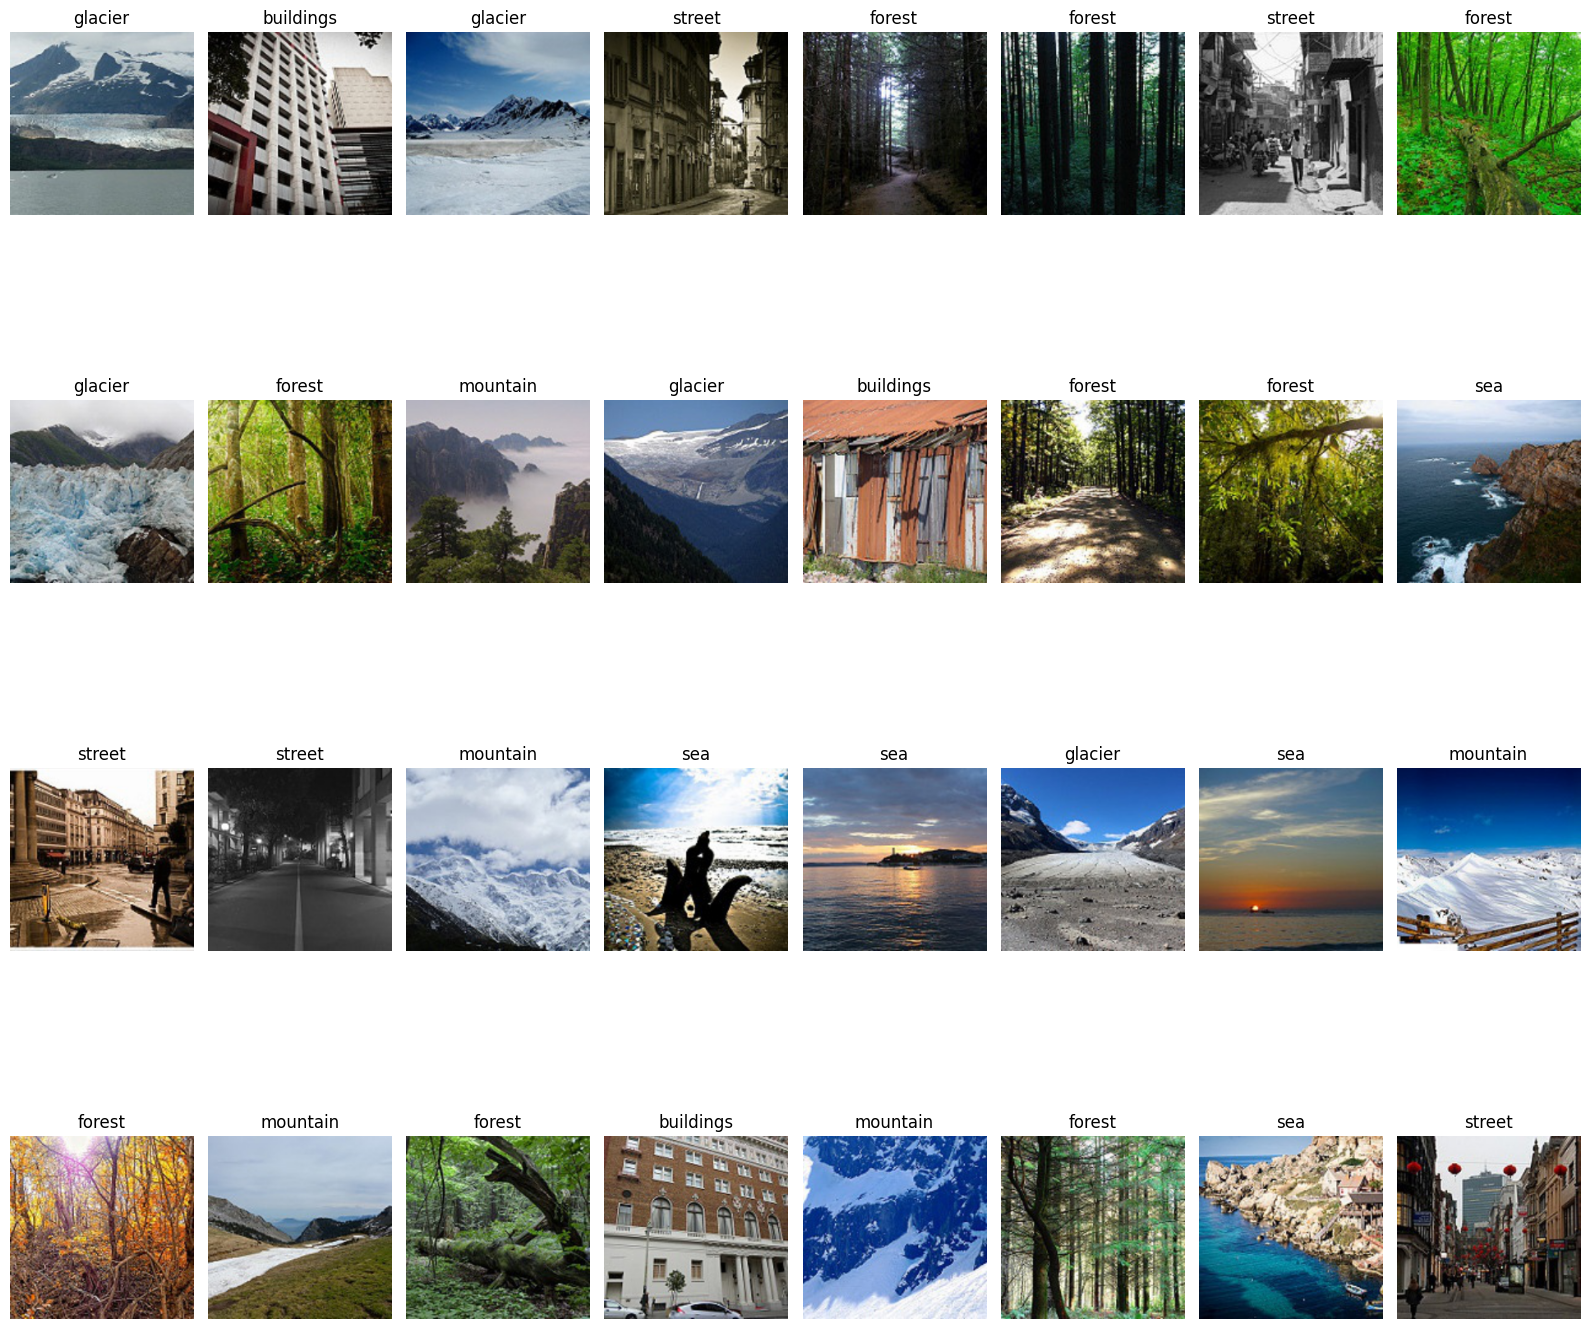

In [39]:
visualize_batch(valBatch, classes, "val")

In [129]:
model.eval()
outputs = model(images)
_, predicted = torch.max(outputs, 1)


RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 8.00 GiB total capacity; 6.99 GiB already allocated; 0 bytes free; 7.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [130]:
!nvidia-smi


Sun Dec 25 15:23:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.47       Driver Version: 526.47       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8    13W / 200W |   7895MiB /  8192MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cu